In [ ]:
import pickle
!pip install rouge-score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

def store_data(var, path):
    with open(path+'.pkl', 'wb') as file:
        pickle.dump(var, file)

def load_data(path):    
    with open(path+'.pkl', 'rb') as file:
        var = pickle.load(file)
    return var

path = '/content/drive/MyDrive/My_PY_Notebooks/Thesis/'
import json
with open('/content/drive/MyDrive/My_PY_Notebooks/Thesis/4-model-dataset.json') as f:
  org_data = json.load(f, strict=False)
user_data = load_data('/content/drive/MyDrive/My_PY_Notebooks/Thesis/data_with_distb_v3_roberta') 

In [3]:
user_id = set()
for doc_id, info in org_data.items():
  for u_id in info['u_dict'].keys():
    user_id.add(u_id)

len(user_id)

103

In [4]:
user_pair = set()
for uid in user_id:
  for uid2 in user_id:
    if uid!=uid2:
      user_pair.add((uid,uid2))
      
len(user_pair)

10506

#e-dins

In [28]:
import numpy as np
import scipy as sp
from scipy.special import softmax, kl_div
import pickle
from collections import OrderedDict

def jsd(p, q):

  p, q = np.asarray(p), np.asarray(q)

  if p.sum():
        p = p/p.sum()

  if q.sum():
      q = q/q.sum()

  # p = softmax(p)
  # q = softmax(q)

  m = 0.5 * (p + q)
  return 0.5 * sum(kl_div(p, m)) + 0.5 * sum(kl_div(q, m))
  
def dev_of_uid_pair(dataset, m_id, uid, uid2, doc_id):
    
    def dev(uid1, model_summ_dict, base_summ_dist):
        '''
            Deviation of summary of uid wrt all other summaries 
        '''
        dev_sum = 0
        w = OrderedDict() # so that it'll same order while fetching values and storing back from list 
        lst = []
        i=0

        # calculate weights 
        p, q, r = [], [], []
        for word in model_summ_dict[uid2]:
            p.append(model_summ_dict[uid1][word])
            q.append(model_summ_dict[uid2][word])
            r.append(base_summ_dist[word])

        w[uid2] = jsd(p, q) / jsd(p, r) if jsd(p, r) else 0

        
        dct = {}
        p, q = [], []
        for word in model_summ_dict[uid2]:
            p.append(model_summ_dict[uid1][word])
            q.append(model_summ_dict[uid2][word])
        val = w[uid2] * jsd(p, q) if w[uid2] else 0
        dct[uid2] = val
        dev_sum += val

        return dev_sum, dct

    ratio_wrt_summ = 0

    # user_summ_dict = user_data[doc_id]['u_dict']
    model_summ_dict = dataset[doc_id]['m_dict'][m_id]
    key = model_summ_dict.keys()

    if uid in key and uid2 in key:
      user_summ_dict = user_data[doc_id]['u_dict']

      val, u_dct = dev(uid, user_summ_dict, dataset[doc_id]['doc_text']) # cal all X
      val, m_dct = dev(uid, model_summ_dict, dataset[doc_id]['doc_text']) # cal all 
      
      ratio_wrt_uid2 = 0
      u = u_dct[uid2]
      m = m_dct[uid2]
      if max(u, m):
          ratio_wrt_uid2 += (min(u, m) / max(u, m))
      else:
          ratio_wrt_uid2 += 0

    return ratio_wrt_uid2

In [34]:
user_pair2 = list(user_pair)[:1000]

#EBNR type 2

In [30]:
import math
from scipy.special import softmax
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
def find_personalized_rouge(model_data, user_pair, mid, alpha=0.5, beta=1):
  tot_dev, tot_rouge, tot_personalized_rouge = 0, 0, 0
  tot_rouge_lst, tot_personalized_rouge_lst = [], []
  dct = {}

  for pair in user_pair:
    uid, uid2 = pair[0], pair[1]
    personalized_rouge, rougel, i, dev= 0, 0, 0, 0
    personalized_rouge2, rougel2, dev2= 0, 0, 0
    for docid in model_data:
      if uid in model_data[docid]['u_dict'] and uid2 in model_data[docid]['u_dict']:
        u_summ, m_summ = org_data[docid]['u_dict'][uid], org_data[docid]['m_dict'][mid][uid]
        u_summ2, m_summ2 = org_data[docid]['u_dict'][uid2], org_data[docid]['m_dict'][mid][uid2]
        
        rl = scorer.score(u_summ, m_summ)['rougeL'][2]
        rl2 = scorer.score(u_summ2, m_summ2)['rougeL'][2]
        rougel += rl
        rougel2 += rl2

        dev += dev_of_uid_pair(model_data, mid, uid, uid2, docid)
        dev2 += dev_of_uid_pair(model_data, mid, uid2, uid, docid)
        # personalized_rouge += x
        # personalized_rouge2 += x
        i+=1

    tot_dev = dev/i
    rougel = rougel/i
    edis = 1- tot_dev
    personalized_rouge = rougel * (1 - (alpha * sigmoid((beta*edis)/rougel))) if rougel else 0

    tot_dev2 = dev2/i
    rougel2 = rougel2/i
    edis2 = 1- tot_dev2
    personalized_rouge2 = rougel2 * (1 - (alpha * sigmoid((beta*edis2)/rougel2))) if rougel2 else 0

    avg_r = (rougel+rougel2)/2
    avg_pr = (personalized_rouge+personalized_rouge2)/2
    tot_rouge += avg_r
    tot_personalized_rouge  += avg_pr
    tot_rouge_lst.append(avg_r)
    tot_personalized_rouge_lst.append(avg_pr)
    dct[pair] = [avg_r, avg_pr]

  tot_rouge /= len(user_id)
  tot_personalized_rouge /= len(user_id)

  

  return tot_rouge, tot_personalized_rouge, dct

eps= 0.001

In [31]:
11/eps, (11+eps)/eps, 11-0.001

(11000.0, 11001.0, 10.999)

In [29]:
mid = '6'
model_data = load_data('/content/drive/MyDrive/My_PY_Notebooks/Thesis/data_with_distb_EBNR_2_roberta') 

In [32]:
tot_rouge, tot_personalized_rouge, user_pair_score_dct = find_personalized_rouge(model_data, user_pair, mid, alpha=0.5, beta=1)
tot_rouge, tot_personalized_rouge, len(user_pair_score_dct)

(23.776039953257204, 12.151737329042891, 10506)

In [56]:
k=0
for i in user_pair_score_dct:
  k+=1
  if k==10:
    break
  print(user_pair_score_dct[i][0], user_pair_score_dct[i][1])

0.21994555357291493 0.11116610616049119
0.17432742409522595 0.08744827955276216
0.18779575181535968 0.0944841971572726
0.21274394772017505 0.10733879268602897
0.2178803043934623 0.11003544176364276
0.2716554037538019 0.14078523612027055
0.2484595101927496 0.12641547459729596
0.269466887210022 0.13864293155237958
0.20971232626052147 0.10576573214932142


In [ ]:
user_pair_score_dct

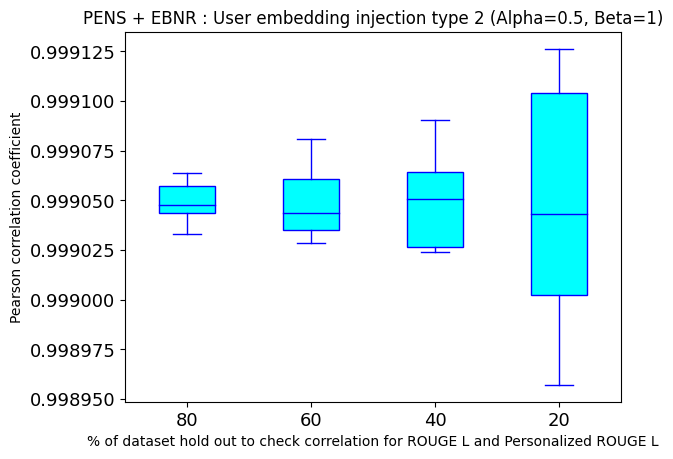

In [39]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='pearson')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + EBNR : User embedding injection type 2 (Alpha=0.5, Beta=1)')
plt.show()

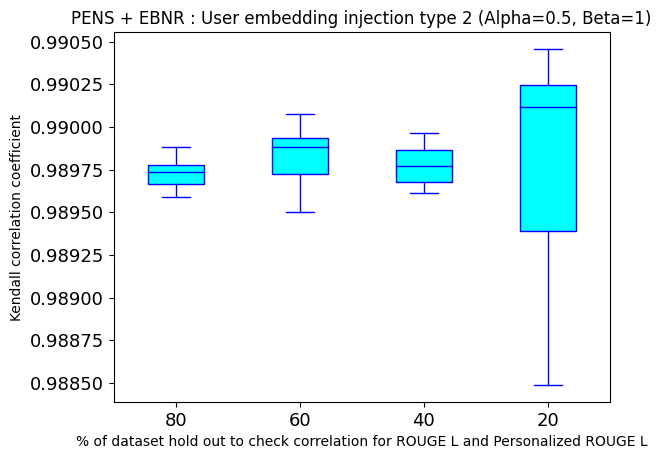

In [40]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='kendall')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Kendall correlation coefficient', fontsize = 10)
plt.title('PENS + EBNR : User embedding injection type 2 (Alpha=0.5, Beta=1)')
plt.show()

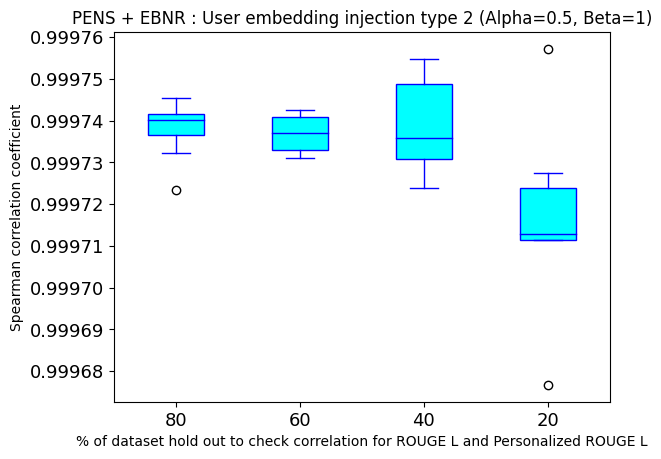

In [41]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='spearman')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Spearman correlation coefficient', fontsize = 10)
plt.title('PENS + EBNR : User embedding injection type 2 (Alpha=0.5, Beta=1)')
plt.show()

#NAML type 1

In [58]:
mid = '2'
model_data_NAML = load_data('/content/drive/MyDrive/My_PY_Notebooks/Thesis/data_with_distb_NAML_roberta') 

In [59]:
tot_rouge_NAML, tot_personalized_rouge_NAML, user_pair_score_dct_NAML = find_personalized_rouge(model_data_NAML, user_pair, mid, alpha=0.5, beta=1)
tot_rouge_NAML, tot_personalized_rouge_NAML, len(user_pair_score_dct_NAML)

(23.69789278467673, 12.178350933062392, 10506)

In [60]:
k=0
for i in user_pair_score_dct_NAML:
  k+=1
  if k==10:
    break
  print(user_pair_score_dct_NAML[i][0], user_pair_score_dct_NAML[i][1])

0.2423687087688092 0.12410978797284193
0.17726632719246377 0.08894668166474004
0.2528261371888823 0.12972655703702712
0.25156987869366565 0.12811036914483337
0.20264066285738114 0.10303115087547142
0.26575247658996076 0.13629247043545867
0.281192049229225 0.14450657482196275
0.29773082641077314 0.15393095996684142
0.23792630095861997 0.12129829885580634


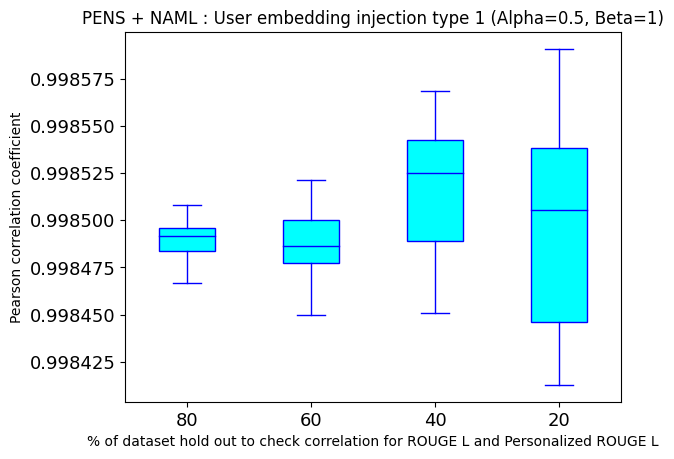

In [78]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='pearson')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct_NAML)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

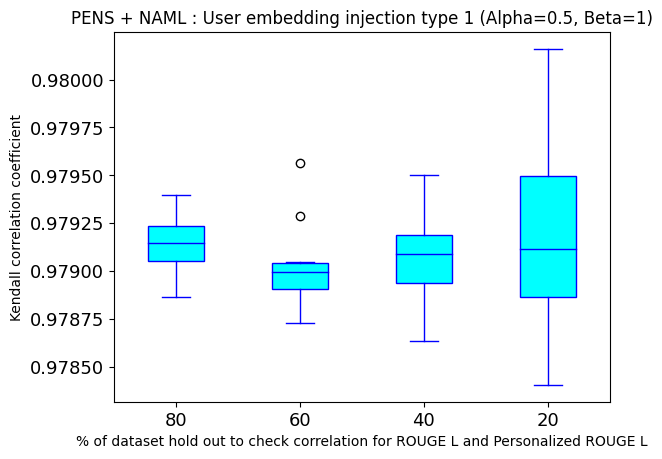

In [77]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst, method='kendall')
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct_NAML)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Kendall correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

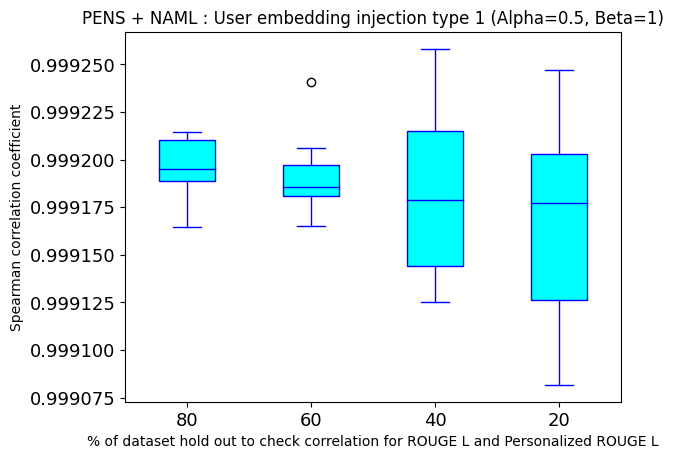

In [76]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method='spearman')

    return correlation_with_rl

def box_plot_data2(percent_data_lst, user_pair_score_dct):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(user_pair_score_dct) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []
    lst = list(user_pair_score_dct.values())
    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            
            new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst = [], []
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              # print(lst[idx][0],lst[idx][1])
              new_user_wise_rouge_lst.append(lst[idx][0])
              new_user_wise_personalized_rouge_lst.append(lst[idx][1])
                
            correl = find_corr(new_user_wise_rouge_lst, new_user_wise_personalized_rouge_lst)
            correl_rl_lst.append(correl)
        
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.8, 0.6, 0.4, 0.2]
plot_data_pearson = box_plot_data2(percent_data_lst, user_pair_score_dct_NAML)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], [int(x*100) for x in percent_data_lst])

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation for ROUGE L and Personalized ROUGE L', fontsize = 10)
plt.ylabel('Spearman correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1 (Alpha=0.5, Beta=1)')
plt.show()

#tmp

In [24]:
'''import math
def dev_of_uid(dataset, m_id, uid, doc_id):
    
    def dev(uid1, model_summ_dict, base_summ_dist):
        '''
            Deviation of summary of uid wrt all other summaries 
        '''
        dev_sum = 0
        w = OrderedDict() # so that it'll same order while fetching values and storing back from list 
        lst = []
        i=0

        # calculate weights 
        for uid2 in model_summ_dict:
            # to make sure each list contains score of same sequence of words
            p, q, r = [], [], []
            for word in model_summ_dict[uid2]:
                p.append(model_summ_dict[uid1][word])
                q.append(model_summ_dict[uid2][word])
                r.append(base_summ_dist[word])

            w[uid2] = jsd(p, q) / jsd(p, r) if jsd(p, r) else 0

            lst.append(w[uid2])

        # apply softmax and store back to dict
        lst = softmax(np.array(lst))
        for uid2 in model_summ_dict:
            w[uid2] = lst[i]
            i+=1
        dct = {}
        for uid2 in model_summ_dict:
            if uid1 != uid2:
                p, q = [], []
                for word in model_summ_dict[uid2]:
                    p.append(model_summ_dict[uid1][word])
                    q.append(model_summ_dict[uid2][word])
                val = w[uid2] * jsd(p, q) if w[uid2] else 0
                dct[uid2] = val
                dev_sum += val

        return dev_sum, dct

    ratio_wrt_summ = 0

    
    user_summ_dict = user_data[doc_id]['u_dict']
    model_summ_dict = dataset[doc_id]['m_dict'][m_id] 

    val, u_dct = dev(uid, user_summ_dict, dataset[doc_id]['doc_text']) # cal all X
    val, m_dct = dev(uid, model_summ_dict, dataset[doc_id]['doc_text']) # cal all 
    
    ratio_wrt_uid2 = 0
    for uid2 in u_dct:
        u = u_dct[uid2]
        m = m_dct[uid2]
        if max(u, m):
            ratio_wrt_uid2 += (min(u, m) / max(u, m))
        else:
            ratio_wrt_uid2 += 0
    
    if len(u_dct):
        ratio_wrt_uid2 /= len(u_dct)

    return ratio_wrt_uid2
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def find_personalized_rouge(mid,  alpha= 0.5, beta=1):
  tot_dev, tot_rouge, tot_personalized_rouge = 0, 0, 0
  tot_rouge_lst, tot_personalized_rouge_lst = [], []
  for uid in list(user_id):
    personalized_rouge, rouge, i, dev= 0, 0, 0, 0
    for docid in model_data:
      if uid in model_data[docid]['u_dict']:
        u_summ, m_summ = org_data[docid]['u_dict'][uid], org_data[docid]['m_dict'][mid][uid]
        rl = scorer.score(u_summ, m_summ)['rougeL'][2]
        dev += dev_of_uid(model_data, mid, uid, docid)
        
        i+=1
        rouge += rl

    tot_dev = dev/i
    tot_rouge += rouge/i
    x = rouge/i
    edis = 1- tot_dev
    personalized_rouge = x * (1 - (alpha * sigmoid((beta*edis)/x)) ) 
    tot_personalized_rouge  += personalized_rouge
    tot_rouge_lst.append(rouge/i)
    tot_personalized_rouge_lst.append(personalized_rouge)

  tot_rouge /= len(user_id)
  tot_personalized_rouge /= len(user_id)

  return tot_rouge, tot_personalized_rouge, tot_rouge_lst, tot_personalized_rouge_lst 

mid = '2'
eps= 0.001
tot_rouge, tot_personalized_rouge, tot_rouge_lst, personalized_rouge_lst = find_personalized_rouge(mid, 0.5,1)
percent_data_lst = [0.8, 0.6, 0.4, 0.2, 0.1]
tot_rouge, tot_personalized_rouge'''

(0.23045988323744424, 0.11798425481237564)